<center><img src="https://github.com/nathaliag30/Clasificador-para-la-detecci-n-de-cancer-de-seno/blob/master/b1%20(1).png?raw=true" style="width:100%;heigth:300
px"></center>




# <center> **ACCIDENT PREDICTION** </center>

Integrantes:

*   Anngy Nathalia Gómez Avila 
*   Andrea Fabiana Villamizar Ruiz
*   Maria Fernanda Vera Negrón



In [0]:
import pandas as pd
import numpy as np
import plotly
import plotly.offline as plt
import plotly.graph_objs as go
import plotly.figure_factory as ff
import seaborn as sns
import matplotlib as mplt
import matplotlib.pylab as plt
%matplotlib inline
%matplotlib inline

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


<H3><B>READING DATASET</B></H3>



>

El dataset que se cargo a continuación contiene distintas aspectos de los accidentes,los cuales estan divididos en datasets independientes.La division de estos datos consiste en 5 archivos que son:


1.   Caracteristicas
2.   Temporada
3.   Lugares
4.   Vehiculos
5.   Usuarios

Para el proposito de este proyecto los datos que son de interes estan almacenados en Caracteristicas, por lo tanto este dataset sera el utilizado para la predicción mediante Time Series



In [0]:
caracteristicas= pd.read_csv('/content/drive/My Drive/AccidentPrediction/data/caracteristics.csv', encoding = "ISO-8859-1", low_memory=False)
temporada=pd.read_csv('/content/drive/My Drive/AccidentPrediction/data/holidays.csv',low_memory=False)
lugares=pd.read_csv('/content/drive/My Drive/AccidentPrediction/data/places.csv',low_memory=False)
vehiculos=pd.read_csv('/content/drive/My Drive/AccidentPrediction/data/vehicles.csv',low_memory=False)
usuarios=pd.read_csv('/content/drive/My Drive/AccidentPrediction/data/users.csv',low_memory=False)

Mapping = {
    'Num_Acc':'NumAccidentes',
    'jour':'Dia',
    'mois':'Mes',
    'an':'Año',
    'hrmn':'Hora',
    'lum':'Condicionluz',
    'dep':'Departamento',
    'com':'Municipio',
    'agg':'Localizacion',
    'int':'Interseccion',
    'atm':'CondicioAtmosferica',
    'col':'TipoColision',
    'adr':'CodigoPostal',
    'gps':'Gps',
    'lat':'Latitud',
    'long':'Longitud',
    'catr':'CategoriaCarretera',
    'voie':'NumeroCategoria',
    'v1':'NumeroRuta',
    'v2':'NombreRuta',
    'circ':'TipoTrafico',
    'nbv':'NumeroCarriles',
    'vosp':'CarrilExterior',
    'Prof':'PerfilCarretera',
    'pr':'CasaPRnumero',
    'pr1':'DistanciPR',
    'plan':'Estrcutura',
    'lartpc':'AnchoTierraCentral',
    'larrout':'AnchoCarrtera',
    'surf':'CondicionAmbiente',
    'infra':'Infrastructure',
    'situ':'SituacionAccidente',
    'env1':'PuntoCercanoEscuela',
    'Acc_number':'AccidentID',
    'Num_Veh':'NumerodeVehiculo',
    'place':'Lugar',
    'catu':'CategoriaUsuario',
    'grav':'Severidad',
    'Year_on':'AñoNacimiento',#año de nacimineto del usuario
    'locp':'LocalizacionPeaton',
    'actp':'AccionPeaton',
    'etatp':'PeatonGrupo',
    'sexe' : 'Sexo',
    'secu':'EquipoSeguridad'
}

In [0]:
#cambios de atiquetas por el diccionario establecido "Mapping"
caracteristicas.rename(index=str, columns=Mapping, inplace=True)
temporada.rename(index=str, columns=Mapping, inplace=True)
lugares.rename(index=str, columns=Mapping, inplace=True)
usuarios.rename(index=str, columns=Mapping, inplace=True)
vehiculos.rename(index=str, columns=Mapping, inplace=True)

In [0]:
caracteristicas['Año']=caracteristicas['Año'].astype(str) #conversion de tipo int a tipo string 
car = { #diccionario para cambio de enumeración de los años
    '5':'2005',
    '6':'2006',
    '7':'2007',
    '8':'2008',
    '9':'2009',
    '10':'2010',
    '11':'2011',
    '12':'2012',
    '13':'2013',
    '14':'2014',
    '15':'2015',
    '16':'2016'
}

caracteristicas['Año'].replace(car, inplace=True)

In [0]:
caracteristicas.shape

(839985, 16)

In [0]:
print(caracteristicas.head())

   NumAccidentes   Año  Mes  Dia  ...  Gps  Latitud  Longitud  Departamento
0   201600000001  2016    2    1  ...    M      0.0         0           590
1   201600000002  2016    3   16  ...    M      0.0         0           590
2   201600000003  2016    7   13  ...    M      0.0         0           590
3   201600000004  2016    8   15  ...    M      0.0         0           590
4   201600000005  2016   12   23  ...    M      0.0         0           590

[5 rows x 16 columns]


In [0]:
caracteristicas1=caracteristicas

<h4>Agrupación por dias</h4>

In [0]:
#Agrupacion de numero de accidentes por cantidad de accidentes
def create_stack_bar_data( df,day,año,mes):
    aggregated = df.groupby([año,mes])[day].value_counts().sort_index()

    x_values =pd.DataFrame(aggregated.index.tolist()) 
    y_values = np.array(aggregated.values.tolist())
  
    return x_values, y_values

x2, y2 = create_stack_bar_data( caracteristicas1,'Dia','Año','Mes')

In [0]:
#Union de la fecha en formato aa/mm/dd
df4 = pd.DataFrame({'year': x2[:][0],
                   'month':x2[:][1],
                   'day': x2[:][2]})
df4=pd.to_datetime(df4) #conversion de dataframe a datatime

In [0]:
data1 = {'Fecha':df4,
        'Accidente':pd.Series(y2)}
 
# Create DataFrame
data1 = pd.DataFrame(data1)
print(data1)

          Fecha  Accidente
0    2005-01-01        180
1    2005-01-02        137
2    2005-01-03        234
3    2005-01-04        279
4    2005-01-05        270
...         ...        ...
4378 2016-12-27        144
4379 2016-12-28        139
4380 2016-12-29        110
4381 2016-12-30        125
4382 2016-12-31         92

[4383 rows x 2 columns]


In [0]:
data1.set_index('Fecha', inplace=True)

In [0]:
data1.head()

,Accidente
Fecha,
2005-01-01,180
2005-01-02,137
2005-01-03,234
2005-01-04,279
2005-01-05,270


In [0]:
ts1 = data1['Accidente']
ts1=ts1[:2000]
print(ts1)

Fecha
2005-01-01    180
2005-01-02    137
2005-01-03    234
2005-01-04    279
2005-01-05    270
             ... 
2010-06-19    210
2010-06-20    154
2010-06-21    223
2010-06-22    237
2010-06-23    204
Name: Accidente, Length: 2000, dtype: int64


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



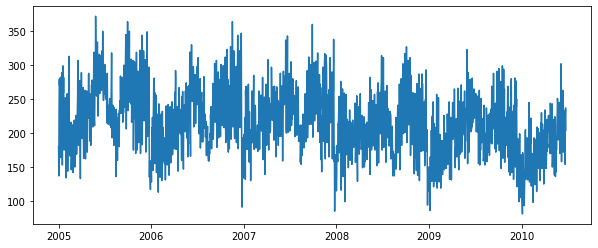

In [0]:
plt.figure(figsize=(10,4))
plt.plot(ts1)

In [0]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
#Plot rolling statistics:
    plt.plot(timeseries, color='c',label='Original')
    plt.plot(rolmean, color='m', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    ## Prueba de Dickey-fuller: esta es una de las pruebas estadísticas para verificar la estacionariedad. 
    #Primero consideramos la hipótesis nula: la serie temporal no es estacionaria. 
    #El resultado del resto contendrá la estadística de prueba y el valor crítico para diferentes niveles de 
    #confianza. La idea es tener estadísticas de prueba inferiores al valor crítico, en este caso podemos rechazar 
    #la hipótesis nula y decir que esta serie de tiempo es estacionaria
    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

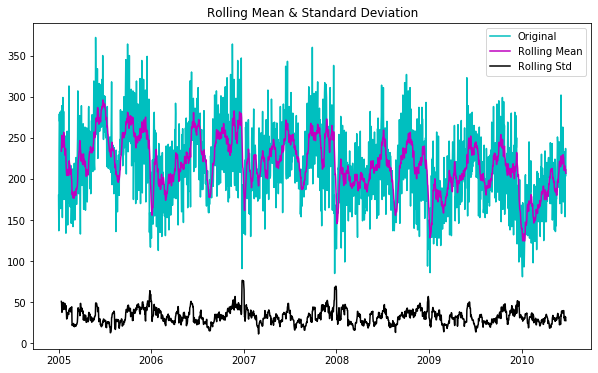

Results of Dickey-Fuller Test:
Test Statistic                   -4.897379
p-value                           0.000035
#Lags Used                       21.000000
Number of Observations Used    1978.000000
Critical Value (1%)              -3.433660
Critical Value (5%)              -2.863002
Critical Value (10%)             -2.567548
dtype: float64


In [0]:
test_stationarity(ts1)

**Nota:** La serie es  estacionaria, ya que el **pvalue<α** .

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



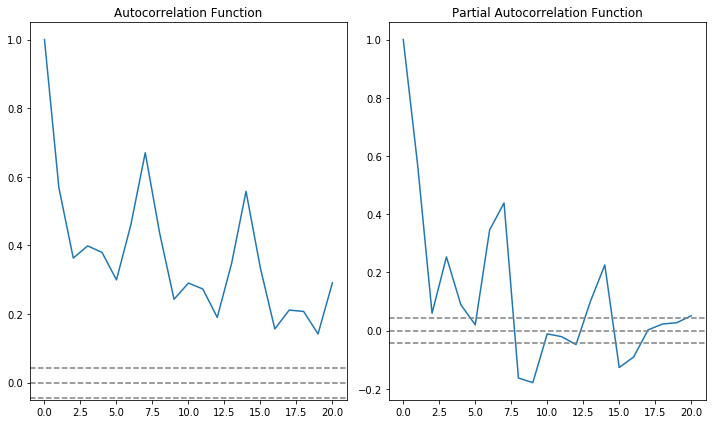

In [0]:
#ACF & PACF plots
lag_acf = acf(ts1, nlags=20)
lag_pacf = pacf(ts1, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts1)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts1)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts1)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts1)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()

En nuestro caso d=1 ya que a la serie de tiempo ya se le aplico time shifting,p=5 y q=0.Estos valores se obtiene con el análisis de las graficas anteriormente mostradas.

<H3><B>ARMA</B></H3

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Plotting AR model


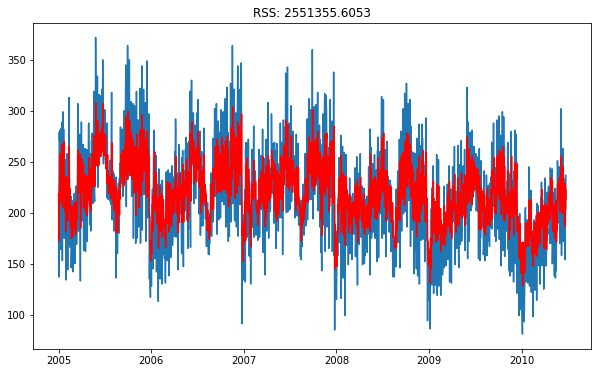

In [0]:
model1 = ARIMA(ts1, order=(5,0,0))
results_AR1 = model1.fit(disp=-1)
plt.plot(ts1)
plt.plot(results_AR1.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR1.fittedvalues - ts1)**2))
print('Plotting AR model')

**Nota** Como podemos ver la agrupación de los accidentes por dias no da un error demasiado alto por lo tanto procedemos a relizar la agrupación por meses

<H4>Agrupación por meses </h4>

In [0]:
caracteristicas['Dia']=1
caracteristicas.head()

,NumAccidentes,Año,Mes,Dia,Hora,Condicionluz,Localizacion,Interseccion,CondicioAtmosferica,TipoColision,Municipio,CodigoPostal,Gps,Latitud,Longitud,Departamento
0,201600000001,2016,2,1,1445,1,2,1,8.0,3.0,5.0,"46, rue Sonneville",M,0.0,0,590
1,201600000002,2016,3,1,1800,1,2,6,1.0,6.0,5.0,1a rue du cimetière,M,0.0,0,590
2,201600000003,2016,7,1,1900,1,1,1,1.0,6.0,11.0,NaN,M,0.0,0,590
3,201600000004,2016,8,1,1930,2,2,1,7.0,3.0,477.0,52 rue victor hugo,M,0.0,0,590
4,201600000005,2016,12,1,1100,1,2,3,1.0,3.0,11.0,rue Joliot curie,M,0.0,0,590


In [0]:
#Agrupacion de numero de accidentes por cantidad de accidentes
def create_stack_bar_data( df,day,año,mes):
    aggregated = df.groupby([año,mes])[day].value_counts().sort_index()

    x_values =pd.DataFrame(aggregated.index.tolist()) 
    y_values = np.array(aggregated.values.tolist())
  
    return x_values, y_values

x1, y1 = create_stack_bar_data( caracteristicas,'Dia','Año','Mes')

In [0]:
#Union de la fecha en formato aa/mm/dd
df3 = pd.DataFrame({'year': x1[:][0],
                   'month':x1[:][1],
                   'day': x1[:][2]})
df3=pd.to_datetime(df3) #conversion de dataframe a datatime


In [0]:
#Union de la fecha del accidente con la cantidad de accidentes ocurridos en esa fecha
data = {'Fecha':df3,
        'Accidente':pd.Series(y1)}
 
# Create DataFrame
data = pd.DataFrame(data)
print(data)

         Fecha  Accidente
0   2005-01-01       7125
1   2005-02-01       5568
2   2005-03-01       6569
3   2005-04-01       6618
4   2005-05-01       7832
..         ...        ...
139 2016-08-01       4311
140 2016-09-01       5408
141 2016-10-01       5596
142 2016-11-01       5356
143 2016-12-01       5110

[144 rows x 2 columns]


In [0]:
data.set_index('Fecha', inplace=True)#seleccionamos la fecha como el indice de nuestra serie de tiempo
print(data.head(10))

            Accidente
Fecha                
2005-01-01       7125
2005-02-01       5568
2005-03-01       6569
2005-04-01       6618
2005-05-01       7832
2005-06-01       8469
2005-07-01       7658
2005-08-01       6479
2005-09-01       7917
2005-10-01       8057


In [0]:
ts = data['Accidente'] #eliminamos la etiqueta Accidente
ts=ts[:2000]
print(ts)

Fecha
2005-01-01    7125
2005-02-01    5568
2005-03-01    6569
2005-04-01    6618
2005-05-01    7832
              ... 
2016-08-01    4311
2016-09-01    5408
2016-10-01    5596
2016-11-01    5356
2016-12-01    5110
Name: Accidente, Length: 144, dtype: int64


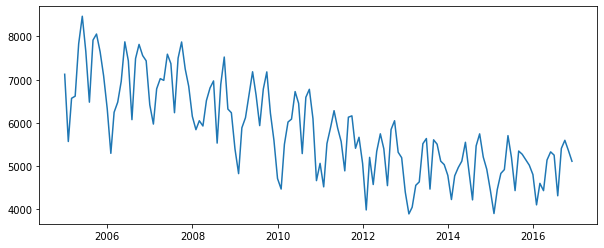

In [0]:
plt.figure(figsize=(10,4))
plt.plot(ts)

<H3><B>TEST DE ESTACIONARIDAD</B></H3

In [0]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
#Plot rolling statistics:
    plt.plot(timeseries, color='c',label='Original')
    plt.plot(rolmean, color='m', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    ## Prueba de Dickey-fuller: esta es una de las pruebas estadísticas para verificar la estacionariedad. 
    #Primero consideramos la hipótesis nula: la serie temporal no es estacionaria. 
    #El resultado del resto contendrá la estadística de prueba y el valor crítico para diferentes niveles de 
    #confianza. La idea es tener estadísticas de prueba inferiores al valor crítico, en este caso podemos rechazar 
    #la hipótesis nula y decir que esta serie de tiempo es estacionaria
    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

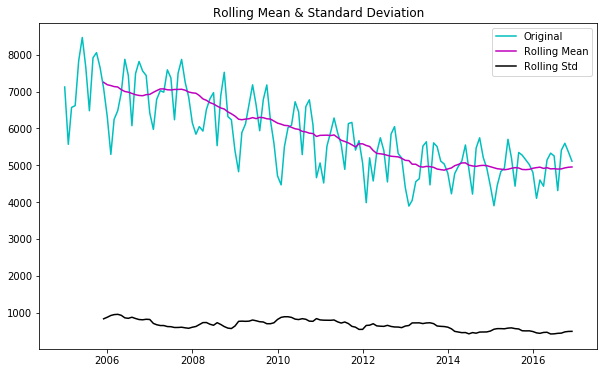

Results of Dickey-Fuller Test:
Test Statistic                  -1.327435
p-value                          0.616529
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [0]:
test_stationarity(ts)

**Nota:** La serie es NO estacionaria, ya que el **pvalue>α** .


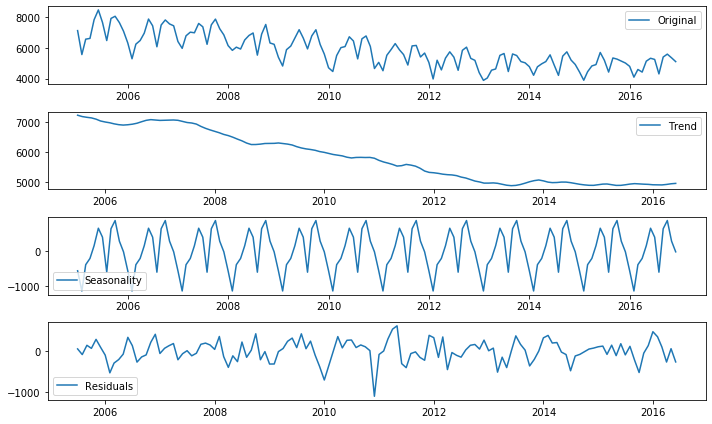

In [0]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

<H3><B>TIME SHIFTING</B></H3

In [0]:
ts_log = np.log(ts)
plt.figure(figsize=(8,4))
plt.plot(ts_log)

In [0]:
print(type(ts_log))

<class 'pandas.core.series.Series'>


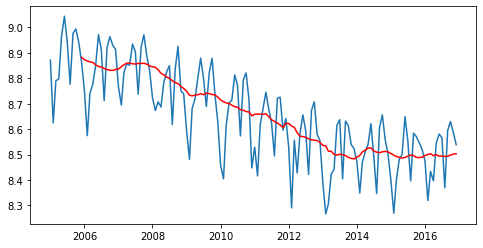

In [0]:
rolmean = ts_log.rolling(window=12).mean()  ###media del ventaneo??
plt.figure(figsize = (8,4))
plt.plot(ts_log)
plt.plot(rolmean, 'red')

In [0]:
ts_log_rolmean_diff = ts_log- rolmean
ts_log_rolmean_diff.head(13)

Fecha
2005-01-01         NaN
2005-02-01         NaN
2005-03-01         NaN
2005-04-01         NaN
2005-05-01         NaN
2005-06-01         NaN
2005-07-01         NaN
2005-08-01         NaN
2005-09-01         NaN
2005-10-01         NaN
2005-11-01         NaN
2005-12-01   -0.016447
2006-01-01   -0.120556
Name: Accidente, dtype: float64

In [0]:
ts_log_rolmean_diff.dropna(inplace=True)
ts_log_rolmean_diff.head()

Fecha
2005-12-01   -0.016447
2006-01-01   -0.120556
2006-02-01   -0.294287
2006-03-01   -0.124865
2006-04-01   -0.086170
Name: Accidente, dtype: float64

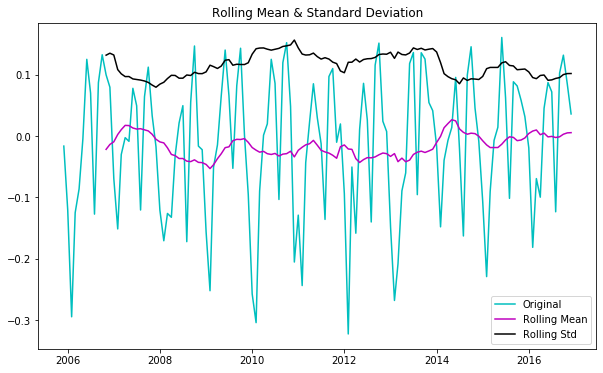

Results of Dickey-Fuller Test:
Test Statistic                  -2.868937
p-value                          0.049081
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [0]:
test_stationarity(ts_log_rolmean_diff)

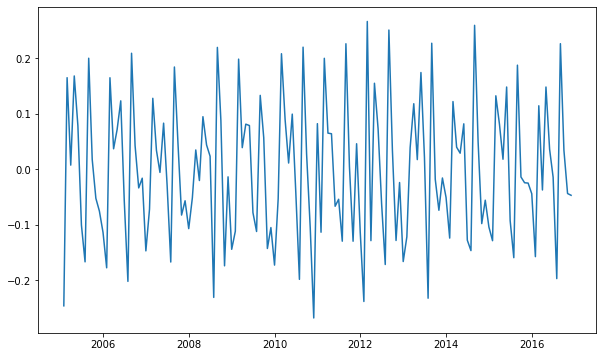

In [0]:
ts_log_diff_shifting = ts_log - ts_log.shift()
plt.plot(ts_log_diff_shifting)

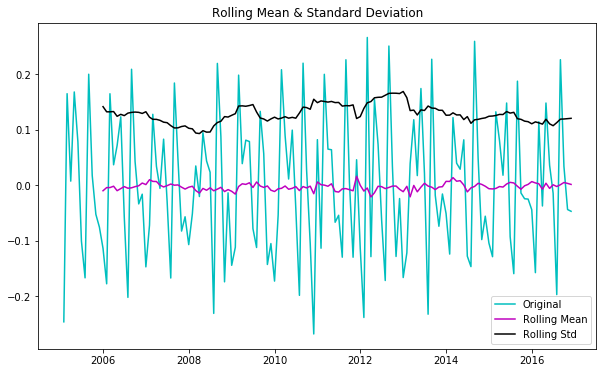

Results of Dickey-Fuller Test:
Test Statistic                  -4.798546
p-value                          0.000055
#Lags Used                      12.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [0]:
ts_log_diff_shifting.dropna(inplace=True)
test_stationarity(ts_log_diff_shifting)

Como podemos analizar con el test de estacionaridad nuestra serie de tiempo ya es estacionaria ya que nuestro **pvalue<α** 

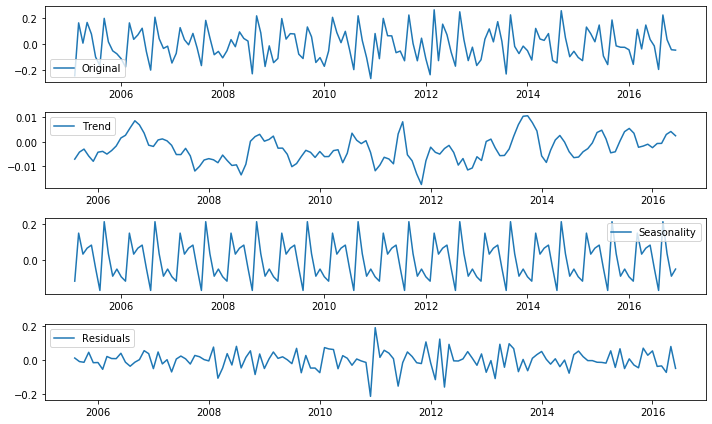

In [0]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log_diff_shifting)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


plt.subplot(411)
plt.plot(ts_log_diff_shifting, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

<H3><B>ACF Y PACF</B></H3

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



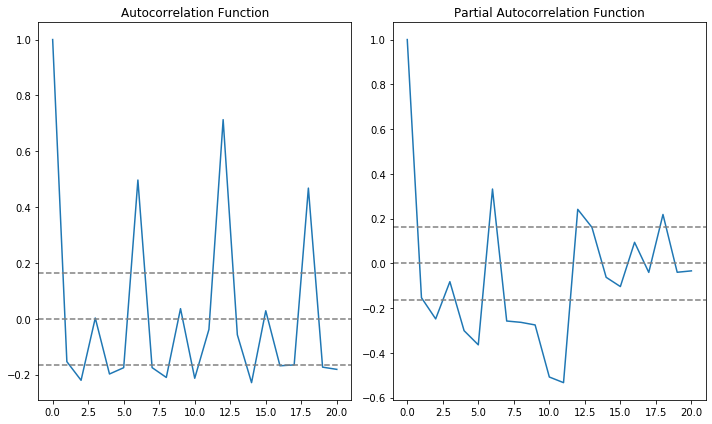

In [0]:
#ACF & PACF plots
lag_acf = acf(ts_log_diff_shifting, nlags=20)
lag_pacf = pacf(ts_log_diff_shifting, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff_shifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff_shifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff_shifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff_shifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()

En nuestro caso d=0 ya que a la serie de tiempo ya se le aplico time shifting,p=10 y q=3.Estos valores se obtiene con el análisis de las graficas anteriormente mostradas.

<H3><B>ARMA</B></H3

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Plotting AR model


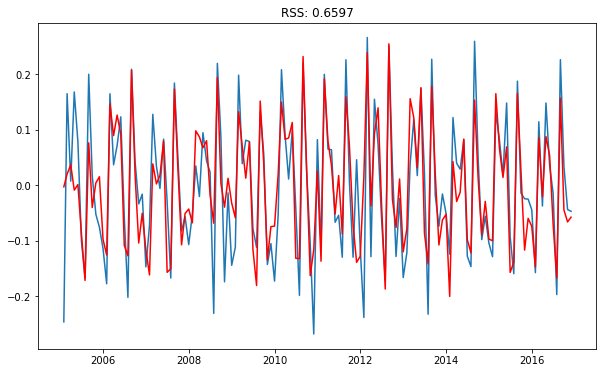

In [0]:
model = ARIMA(ts_log_diff_shifting, order=(10,0,3))
results_AR = model.fit(disp=-1)
plt.plot(ts_log_diff_shifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - ts_log_diff_shifting)**2))
print('Plotting AR model')

<H3><B>PREDICCIÓN</B></H3>

In [0]:
predictions_AR_diff=pd.Series(results_AR.fittedvalues,copy=True)
print(predictions_AR_diff.head())

Fecha
2005-02-01   -0.002904
2005-03-01    0.020141
2005-04-01    0.036907
2005-05-01   -0.008845
2005-06-01    0.001200
dtype: float64


In [0]:
predictions_AR_diff_cumsum=predictions_AR_diff.cumsum()
print(predictions_AR_diff_cumsum.head())

Fecha
2005-02-01   -0.002904
2005-03-01    0.017237
2005-04-01    0.054144
2005-05-01    0.045299
2005-06-01    0.046498
dtype: float64


In [0]:
predictions_AR_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_AR_log = predictions_AR_log.add(predictions_AR_diff_cumsum, fill_value=0)
print(predictions_AR_log)

Fecha
2005-01-01    8.871365
2005-02-01    8.868461
2005-03-01    8.888602
2005-04-01    8.925509
2005-05-01    8.916664
                ...   
2016-08-01    8.358173
2016-09-01    8.515319
2016-10-01    8.470720
2016-11-01    8.404508
2016-12-01    8.346902
Length: 144, dtype: float64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated



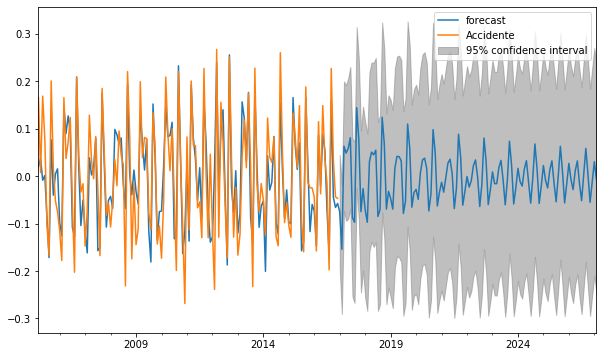

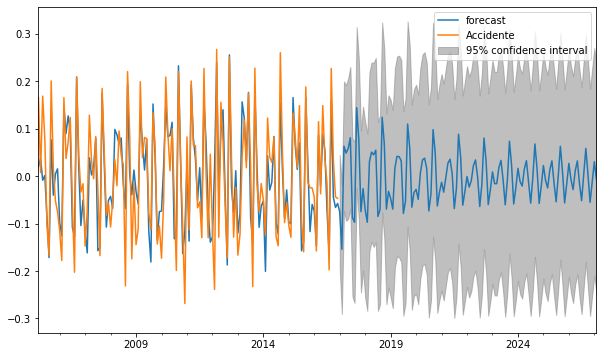

In [0]:
results_AR.plot_predict(1,264) 

In [0]:
ts_s=ts_log.shift()

In [0]:
ts_1=ts_s.dropna()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



Plotting AR model


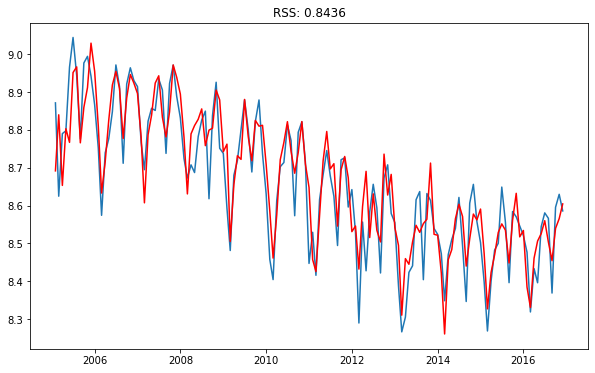

In [0]:
model = ARIMA(ts_1, order=(10,0,3))
results_AR2 = model.fit(disp=-1)
plt.plot(ts_1)
plt.plot(results_AR2.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR2.fittedvalues - ts_1)**2))
print('Plotting AR model')

In [0]:
a=results_AR.forecast(steps=120)[0]+results_AR2.forecast(steps=120)[0]

In [0]:
pre_ar=np.exp(a)

In [0]:
df3[143]


Timestamp('2016-12-01 00:00:00')

In [0]:
from datetime import date
from datetime import timedelta
import datetime as datetime

np.timedelta64(2,'M')
arr = np.array([df3[143] + np.timedelta64(i,'M') for i in range(120)])

In [0]:
pred1=pd.DataFrame(pre_ar).set_index(arr)

In [0]:
pre_ar=pred1[0]

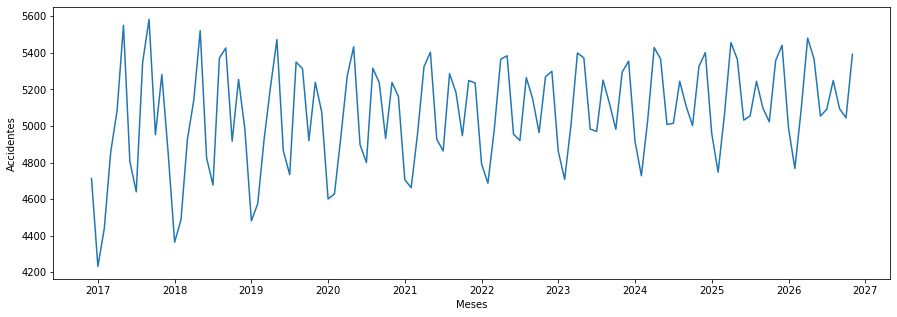

In [0]:
plt.figure(figsize=(15,5))
plt.plot(pre_ar, label='Forecast')




plt.ylabel('Accidentes')
plt.xlabel('Meses')
plt.show()

**<h3>Holt Winter</h3>**

EL método Holt-Winters es un método de pronóstico de triple exponente suavizante y tiene la ventaja de ser fácil de adaptarse a medida que nueva información real está disponible. El método Holt- Winters es una extensión del método Holt que considera solo dos exponentes suavizantes. Holt-Winters considera nivel, tendencia y estacional de una determinada serie de tiempos.

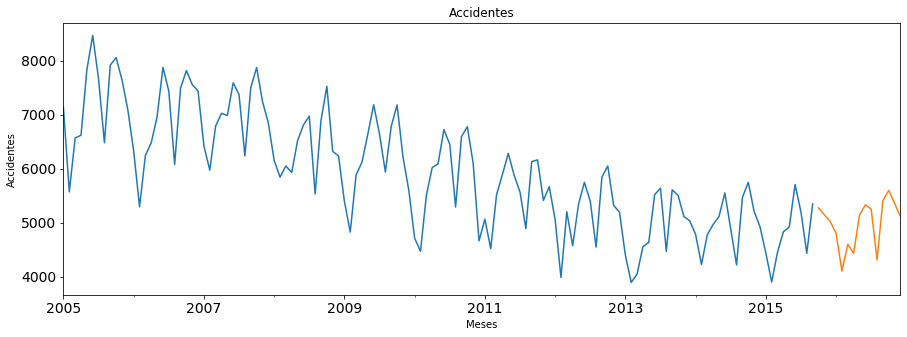

In [0]:
#Separamos la data en train y test
size=int(ts.shape[0]*0.9)
train=ts[:size]
test=ts[size:]
train.plot(kind='line',figsize=(15,8), title= 'Accidentes', fontsize=14)
test.plot(figsize=(15,5), title= 'Accidentes', fontsize=14)
plt.ylabel('Accidentes')
plt.xlabel('Meses')
plt.show()

**Time Shifting**

In [0]:
train_shif=np.log(train)-np.log(train).shift()
n=np.log(test)-np.log(test).shift()

**Training**

In [0]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
fit1 = ExponentialSmoothing(np.asarray(train_shif.dropna()) ,seasonal_periods=6 ,trend='add', seasonal='add',).fit()
y_hat_avg= pd.DataFrame(fit1.forecast(len(test)))


In [0]:
t=y_hat_avg.set_index(ts[size:].index)
predict=pd.Series(t[0])



**Predicción**

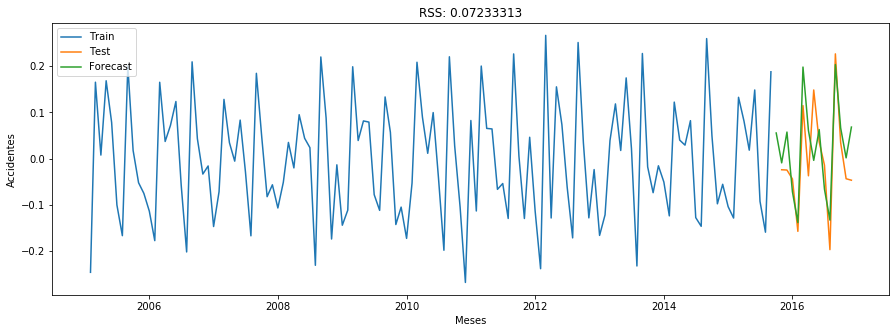

In [0]:
plt.figure(figsize=(15,5))
plt.plot(train_shif, label='Train')
plt.plot(n, label='Test')
plt.plot(predict, label='Forecast')

plt.legend(loc='best')

plt.title('RSS: %.8f'%sum((predict[1:] - n[1:])**2))

plt.ylabel('Accidentes')
plt.xlabel('Meses')
plt.show()

<H3><b>CONCLUSIÓN</b> </H3>

La predicción de la cantidad de accidentes que pueden ocurrir en el mes posterior es de 4712 accidentes
